# Experiments Notebook 1


In [ ]:
!pip install pydot

In [ ]:
!pip install keras-hypetune

In [1]:
import os
import os.path
import pickle
import bz2
from glob import glob
import random
import shutil
from datetime import datetime
from tqdm.auto import tqdm
import importlib


import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from kerashypetune import KerasGridSearch


import preprocessing as pp
import dsci592.model as dsci

In [2]:
importlib.reload(dsci)

<module 'dsci592.model' from '/home/noah/projects/drexel/dsci592/DS-capstone-pt1/code/src/dsci592/model.py'>

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)


### Load the golden data

In [ ]:
# Windows version
golden_dataset_file_name = os.path.join('..', '..', 'data', 'golden', 'feeFiFoFum.pbz2')

# data = bz2.BZ2File(golden_dataset_file_name,'rb')
with bz2.BZ2File(golden_dataset_file_name,'rb') as data:
    df = pd.read_pickle(data)
df

In [10]:
# Linux version (problems with bz2 file)

golden_dataset_file_name = os.path.join('/', 'data', 'projects', 'drexel', 'dsci592', 'feeFiFoFum.pkl')

df = pd.read_pickle(golden_dataset_file_name)
df.head(5)

,dates,JHU_ConfirmedCases.data,NYT_ConfirmedCases.data,JHU_ConfirmedDeaths.data,NYT_ConfirmedDeaths.data,NYT_ConfirmedDeaths.missing,TotalPopulation.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,BLS_UnemployedPopulation.data,BLS_UnemployedPopulation.missing,BLS_UnemploymentRate.data,BLS_UnemploymentRate.missing,BLS_LaborForcePopulation.data,BLS_LaborForcePopulation.missing,AverageDailyTemperature.data,AverageDailyTemperature.missing,AverageDewPoint.data,AverageDewPoint.missing,AverageRelativeHumidity.data,AverageRelativeHumidity.missing,AverageSurfaceAirPressure.data,AverageSurfaceAirPressure.missing,AveragePrecipitationTotal.data,AveragePrecipitationTotal.missing,AveragePrecipitation.data,AveragePrecipitation.missing,AverageWindDirection.data,AverageWindDirection.missing,AverageWindSpeed.data,AverageWindSpeed.missing,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,fips,county,jhu_daily_death,jhu_daily_cases,jhu_daily_new_cases,jhu_daily_death_rolling_7,jhu_daily_cases_rolling_7,jhu_daily_new_cases_rolling_7,jhu_daily_death_rolling_30,jhu_daily_cases_rolling_30,jhu_daily_new_cases_rolling_30,LND110210,jhu_death_rate,jhu_case_rate,jhu_new_case_rate,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,cold_days,hot_days,moderate_days,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent,totalMoved,movedWithinState,movedWithoutState,movedFromAbroad,publicTrans,totalTrans,householdsTotal,houseWith65,house2+with65,houseFamily65,houseNonfam65,houseNo65,house2+No65,houseFamilyNo65,houseNonfamNo65,householdStructuresTotal,householdIncomeMedian,gini,hoursWorkedMean,unitsInStructure,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,countyStateName,stateFip,countyFip,pm25
0,2020-03-19,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,68.659722,0.0,63.152778,0.0,84.152778,0.0,29.590139,0.0,0.000833,0.0,0.000000,0.0,192.326389,0.0,6.732639,0.0,6.0,25.0,25.0,24527.0,45001,Abbeville_SouthCarolina_UnitedStates,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,490.48,0.0,0.0,0.0,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.479,38.1,12191,24397,21415,179,87,39,122,2555,"Abbeville County, South Carolina",45,001,9.618551
1,2020-03-20,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,72.541667,0.0,60.583333,0.0,68.708333,0.0,29.537708,0.0,0.000000,0.0,0.000000,0.0,208.125000,0.0,10.833333,0.0,6.0,25.0,25.0,24527.0,45001,Abbeville_SouthCarolina_UnitedStates,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,490.48,0.0,0.0,0.0,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.479,38.1,12191,24397,21415,179,87,39,122,2555,"Abbeville County, South Carolina",45,001,9.618551
2,2020-03-21,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,69.208333,0.0,56.708333,0.0,66.583333,0.0,29.520417,0.0,0.000000,0.0,0.000000,0.0,252.916667,0.0,8.125000,0.0,6.0,25.0,25.0,24527.0,45001,Abbeville_SouthCarolina_UnitedStates,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,490.48,0.0,0.0,0.0,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.479,38.1,12191,24397,21415,179,87,39,122,2555,"Abbeville County, South Carolina",45,001,9.618551
3,2020-03-22,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,53.916667,0.0,49.770833,0.0,86.395833,0.0,29.

### Clean up the data

#### Drop non-numeric and unnecessary columns

In [11]:
cols = ['NYT_ConfirmedCases.data','NYT_ConfirmedDeaths.data','NYT_ConfirmedDeaths.missing','county','LND110210','countyStateName','stateFip','countyFip']

df.drop(cols, axis=1, inplace=True)

#### Temporarily, replace FIPS codes with latitude and longitude of the centroid of each county

In [12]:
counties = pd.read_csv('2021_Gaz_counties_national.txt', delimiter='\t')
counties.rename(columns={'INTPTLONG                                                                                                               ': 'longitude',
                        'INTPTLAT': 'latitude'}, inplace=True)

In [13]:
counties = counties[['GEOID', 'latitude', 'longitude' ]]
df.fips = df.fips.astype('int64')

df = df.merge(counties, how='left', left_on='fips', right_on='GEOID')
df.drop(['GEOID'], axis=1, inplace=True)

#### Replace dates with monotonically increasing integers starting with the minimum date

In [14]:
df.dates = pd.to_datetime(df.dates, format='%Y-%m-%d')
min_date = min(df.dates)
max_date = max(df.dates)
min_date, max_date, df.dates.dtype

(Timestamp('2020-03-11 00:00:00'),
 Timestamp('2022-01-16 00:00:00'),
 dtype('<M8[ns]'))

In [15]:
df['day'] =(df.dates - min_date).dt.days
df.drop(['dates'], axis=1, inplace=True)

#### Replace the integer representation of date with sin and cosine encoding

In [16]:
cyclical_interval = 365
continuous_interval = 3650
df['cyclical_sin'] = np.sin((df.day * 2 * np.pi)/cyclical_interval)
df['cyclical_cos'] = np.cos((df.day * 2 * np.pi)/cyclical_interval)
df['continuous_sin'] = np.sin((df.day * 2 * np.pi)/continuous_interval)
df['continuous_cos'] = np.cos((df.day * 2 * np.pi)/continuous_interval)
df.drop('day', axis=1, inplace=True)

#### Get the feature column for latitude and longitude

In [17]:
# crossed_latlong = pp.get_latlong_fc(df)

lat_buckets = list(np.linspace(df.latitude.min(), df.latitude.max(),100))
long_buckets = list(np.linspace(df.longitude.min(), df.longitude.max(),100))

#make feature columns
lat_fc = tf.feature_column.bucketized_column(tf.feature_column.numeric_column('latitude'),lat_buckets)
long_fc= tf.feature_column.bucketized_column(tf.feature_column.numeric_column('longitude'),long_buckets)
    
# crossed columns tell the model how the features relate
crossed_latlong = tf.feature_column.crossed_column(keys=[lat_fc, long_fc], hash_bucket_size=1000) # No precise rule, maybe 1000 buckets will be good?
    
embedded_latlong = tf.feature_column.embedding_column(crossed_latlong,9)

feature_layer = tf.keras.layers.DenseFeatures(embedded_latlong)

df[['geo0', 'geo1', 'geo2','geo3', 'geo4','geo5','geo6','geo7','geo8']] = feature_layer({'latitude': df.latitude, 'longitude': df.longitude})

# df.drop(['longitude', 'latitude'], axis=1, inplace=True)

In [18]:
df

,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,TotalPopulation.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,BLS_UnemployedPopulation.data,BLS_UnemployedPopulation.missing,BLS_UnemploymentRate.data,BLS_UnemploymentRate.missing,BLS_LaborForcePopulation.data,BLS_LaborForcePopulation.missing,AverageDailyTemperature.data,AverageDailyTemperature.missing,AverageDewPoint.data,AverageDewPoint.missing,AverageRelativeHumidity.data,AverageRelativeHumidity.missing,AverageSurfaceAirPressure.data,AverageSurfaceAirPressure.missing,AveragePrecipitationTotal.data,AveragePrecipitationTotal.missing,AveragePrecipitation.data,AveragePrecipitation.missing,AverageWindDirection.data,AverageWindDirection.missing,AverageWindSpeed.data,AverageWindSpeed.missing,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,fips,jhu_daily_death,jhu_daily_cases,jhu_daily_new_cases,jhu_daily_death_rolling_7,jhu_daily_cases_rolling_7,jhu_daily_new_cases_rolling_7,jhu_daily_death_rolling_30,jhu_daily_cases_rolling_30,jhu_daily_new_cases_rolling_30,jhu_death_rate,jhu_case_rate,jhu_new_case_rate,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,cold_days,hot_days,moderate_days,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent,totalMoved,movedWithinState,movedWithoutState,movedFromAbroad,publicTrans,totalTrans,householdsTotal,houseWith65,house2+with65,houseFamily65,houseNonfam65,houseNo65,house2+No65,houseFamilyNo65,houseNonfamNo65,householdStructuresTotal,householdIncomeMedian,gini,hoursWorkedMean,unitsInStructure,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25,latitude,longitude,cyclical_sin,cyclical_cos,continuous_sin,continuous_cos,geo0,geo1,geo2,geo3,geo4,geo5,geo6,geo7,geo8
0,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,68.659722,0.0,63.152778,0.0,84.152778,0.0,29.590139,0.0,0.000833,0.0,0.000000,0.0,192.326389,0.0,6.732639,0.0,6.0,25.0,25.0,24527.0,45001,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.4790,38.1,12191,24397,21415,179,87,39,122,2555,9.618551,34.229041,-82.454058,0.137279,0.990532,0.013771,0.999905,-0.206256,0.121853,-0.059924,-0.341429,-0.240499,0.052870,-0.162839,-0.213781,0.165044
1,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,72.541667,0.0,60.583333,0.0,68.708333,0.0,29.537708,0.0,0.000000,0.0,0.000000,0.0,208.125000,0.0,10.833333,0.0,6.0,25.0,25.0,24527.0,45001,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.4790,38.1,12191,24397,21415,179,87,39,122,2555,9.618551,34.229041,-82.454058,0.154309,0.988023,0.015492,0.999880,-0.206256,0.121853,-0.059924,-0.341429,-0.240499,0.052870,-0.162839,-0.213781,0.165044
2,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,69.208333,0.0,56.708333,0.0,66.583333,0.0,29.520417,0.0,0.000000,0.0,0.000000,0.0,252.916667,0.0,8.125000,0.0,6.0,25.0,25.0,24527.0,45001,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.4790,38.1,12191,24397,21415,179,87,39,122,2555,9.618551,34.229041,-82.454058,0.171293,0.985220,0.017213,0.999852,-0.206256,0.121853,-0.059924,-0.341429,-0.2

In [19]:
df.to_pickle('/tmp/df.pkl')

#### Normalize the data

In [ ]:
cols_to_normalize = [
       'TotalPopulation.data', 'MaleAndFemale_AtLeast65_Population.data',
       'Male_Total_Population.data', 'Female_Total_Population.data',
       'MaleAndFemale_Under18_Population.data', 'BLS_EmployedPopulation.data',
       'BLS_EmployedPopulation.missing', 'BLS_UnemployedPopulation.data',
       'BLS_UnemployedPopulation.missing', 'BLS_UnemploymentRate.data',
       'BLS_UnemploymentRate.missing', 'BLS_LaborForcePopulation.data',
       'BLS_LaborForcePopulation.missing', 'AverageDailyTemperature.data',
       'AverageDailyTemperature.missing', 'AverageDewPoint.data',
       'AverageDewPoint.missing', 'AverageRelativeHumidity.data',
       'AverageRelativeHumidity.missing', 'AverageSurfaceAirPressure.data',
       'AverageSurfaceAirPressure.missing', 'AveragePrecipitationTotal.data',
       'AveragePrecipitationTotal.missing', 'AveragePrecipitation.data',
       'AveragePrecipitation.missing', 'AverageWindDirection.data',
       'AverageWindDirection.missing', 'AverageWindSpeed.data',
       'AverageWindSpeed.missing', 'hospitalIcuBeds', 'hospitalStaffedBeds',
       'hospitalLicensedBeds', 'latestTotalPopulation', 'jhu_daily_death',
       'jhu_daily_cases', 'jhu_daily_new_cases', 
    'jhu_daily_death_rolling_7',
       'jhu_daily_cases_rolling_7', 'jhu_daily_new_cases_rolling_7',
       'jhu_daily_death_rolling_30', 'jhu_daily_cases_rolling_30',
       'jhu_daily_new_cases_rolling_30', 'jhu_death_rate', 'jhu_case_rate',
       'jhu_new_case_rate', 'density', 'icu_beds_per_person',
       'staffed_beds_per_person', 'licensed_beds_per_person', 'cold_days',
       'hot_days', 'moderate_days', 'gte_65_percent', 'lt_18_percent',
       'employed_percent', 'unemployed_percent', 'totalMoved',
       'movedWithinState', 'movedWithoutState', 'movedFromAbroad',
       'publicTrans', 'totalTrans', 'householdsTotal', 'houseWith65',
       'house2+with65', 'houseFamily65', 'houseNonfam65', 'houseNo65',
       'house2+No65', 'houseFamilyNo65', 'houseNonfamNo65',
       'householdStructuresTotal', 'householdIncomeMedian', 'gini',
       'hoursWorkedMean', 'unitsInStructure', 'healthInsTotal',
       'healthInsNativeWith', 'healthInsForeignNatWith',
       'healthInsForeignNoncitWith', 'healthInsForeignNatNo',
       'healthInsForeignNoncitNo', 'healthInsNativeNo', 'pm25', 'latitude',
       'longitude']
cols_raw = ['fips','JHU_ConfirmedCases.data', 'JHU_ConfirmedDeaths.data', 'cyclical_sin', 'cyclical_cos', 'continuous_sin',
       'continuous_cos', 'geo0', 'geo1', 'geo2','geo3', 'geo4','geo5','geo6','geo7','geo8']
df_normalized = df[cols_to_normalize]
df_normalized = (df_normalized - df_normalized.mean())/df_normalized.std()
df_raw = df[cols_raw]
df = pd.concat([df_raw, df_normalized], axis=1)


#### Prepare the data for training

In [ ]:
days_of_history = 30
days_to_predict = 1

In [ ]:
fips = df.fips.unique()

# def x_generator(data, days_of_history=30, days_to_predict=1):
#     for j, fip in enumerate(fips):
#         if not j % 100: print(j, end=' ')
#         county = data[data.fips == fip]
#         for i in range(days_of_history, len(county) - days_to_predict):
#             data_matrix = data.iloc[i - days_of_history: i, 1:].to_numpy()
#             yield data_matrix
            
# def y_generator(data, days_of_history=30, days_to_predict=1):
#     for fip in fips:
#         county = data[data.fips == fip]
#         for i in range(days_of_history, len(county) - days_to_predict):
#             data_matrix = data.iloc[i: i + days_to_predict, 1:3].to_numpy()
#             yield data_matrix
    
def xy_generator(data, days=31):
    for j, fip in enumerate(fips):
        if not j % 100: print(j, end=' ')
        county = data[data.fips == fip]
        for i in range(days, len(county) + 1):
            data_matrix = data.iloc[i - days: i, 1:].to_numpy()
            yield data_matrix
            
        
            
    

##### Save the raw X and Y to files of 50,000 sequences

In [ ]:
Xi = []
j = 0

N_SAMPLES = 200

for i, x in enumerate(xy_generator(df)):
    Xi.append(x)
    if i and not i % (N_SAMPLES - 1):
        X = np.asarray(Xi)
        np.save(os.path.join('.','data', f'x_{j}.npy'), X)
        j += 1
        Xi = []
if Xi:
    X = np.asarray(Xi)
    np.save(os.path.join('.','data', f'x_{j}.npy'), X)
 



In [ ]:
x = np.load('./data/x_0.npy')
x.shape

##### Split into train, test, eval directories

In [ ]:
RANDOM_SEED = 42
def set_seed():
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
set_seed()

In [ ]:
x_files = glob('./data/x_*.npy')
random.shuffle(x_files)
n_files = len(x_files)
print(n_files)
n_train = int(n_files * 0.70)
print(n_train)
n_eval = int(n_files * 0.15)
print(n_eval)
n_test = n_files - n_train - n_eval
print(n_test)
train_files = x_files[:n_train]
# print(len(train_files))
eval_files = x_files[n_train:n_train+n_test]
# print(len(eval_files))
test_files = x_files[n_train+n_test:]
assert n_files == len(train_files) + len(eval_files) + len(test_files)
for (subdir, lst) in [['train', train_files], ['eval', eval_files], ['test', test_files]]:
    for file in lst:
        shutil.move(file, os.path.join('.', 'data', subdir))
        

##### Create the Tensorflow Dataset

In [ ]:
train_files = glob('./data/train/x_*.npy')
eval_files = glob('./data/eval/x_*.npy')
test_files = glob('./data/test/x_*.npy')

n_readers = 5
n_parse_threads = 5
len_array = 995

def create_generator(files, cycle_length=5):
    set_seed()
    random.shuffle(files)
    for i in range(0, len(files), cycle_length):
        subset = files[i:i+cycle_length]
        np_arrays = [np.load(s) for s in subset]
        np_array = np.concatenate(np_arrays, axis=0)
        np.random.shuffle(np_array)
        yield np_array
            

def split_xy(np_array):
    X = np_array[:,:-1,:]
    y = np_array[:,-1:,:1]
    return X,y
        
    
train_ds = tf.data.Dataset.from_generator(lambda: create_generator(train_files, cycle_length=n_readers), output_types=tf.float32 )
train_ds = train_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

val_ds = tf.data.Dataset.from_generator(lambda: create_generator(eval_files, cycle_length=n_readers), output_types=tf.float32 )
val_ds = val_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

test_ds = tf.data.Dataset.from_generator(lambda: create_generator(test_files, cycle_length=n_readers), output_types=tf.float32 )
test_ds = test_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)


In [ ]:
# for x in train_ds.take(3):
#     print(x)

## Building the model

In [ ]:
param_grid = {
    'recurrent_layer_type': [keras.layers.LSTM, keras.layers.GRU],
    'n_recurrent': [1, 2, 3],
    'unit': [32, 64, 128],
    'dropout': [0.0, 0.10, 0.20],
    'lr': [1e-2, 1e-3],   
    'epochs': 256,
}

In [ ]:
def build_model(param, shape=(30,101)):
    input = keras.layers.Input(shape=shape)
    last = input
    for i in range(param['n_recurrent']):
        last = param['recurrent_layer_type'](param['unit'])(last)
        if param['dropout']:
            last = keras.layers.Dropout(param['dropout'])(last)
    output = keras.layers.Dense(1)(last)
    model = keras.models.Model(inputs=input, outputs=output)
    model.compile(optimizer = Adam(learning_rate=param['lr']),  loss='mae',  metrics=['mse', 'mae'])
        
    return model


                      

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=10, restore_best_weights=True)

n_trial = 3

name = f'trial_{n_trial}'
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

checkpoint_cb = keras.callbacks.ModelCheckpoint(f'./data/model/{name}_{timestamp}.h5', save_best_only=True)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(name))


hypermodel = lambda param: build_model(param=param)

kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(train_ds, validation_data=val_ds, callbacks=[early_stopping_cb, checkpoint_cb, tensorboard], shuffle=False)


### Hyperparameter tuning 

Using technique from https://medium.com/ml-book/neural-networks-hyperparameter-tuning-in-tensorflow-2-0-a7b4e2b574a1

In [5]:
HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM', 'keras.layers.GRU']))
# HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM']))
HP_N_RECURRENT=hp.HParam('n_recurrent', hp.Discrete([1, 2, 3]))
# HP_N_RECURRENT=hp.HParam('n_recurrent', hp.Discrete([3]))
HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([32, 64, 128, 256]))
# HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([128]))
HP_DROPOUT=hp.HParam('dropout', hp.Discrete([0.00, 0.20]))
HP_LR=hp.HParam('lr', hp.Discrete([1e-2, 1e-3]))
METRIC_MAE = 'mae'


with tf.summary.create_file_writer('logs/hparam_tuning_full_3').as_default():
    hp.hparams_config(
    hparams=[HP_LAYER_TYPE, HP_N_RECURRENT, HP_N_UNIT, HP_DROPOUT, HP_LR],
    metrics=[hp.Metric(METRIC_MAE, display_name='Mean Avg Error')],
  )

In [6]:
EPOCHS=32

def train_test_model(hparams, shape=(30,100)):
    # set_seed()
    train_ds, val_ds, test_ds = dsci.get_train_test_eval_ds()
    input = keras.layers.Input(shape=shape)
    last = input
    for i in range(hparams[HP_N_RECURRENT]):
        if i < hparams[HP_N_RECURRENT] - 1:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT], return_sequences=True)(last)
        else:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT])(last)
        
        if hparams[HP_DROPOUT]:
            last = keras.layers.Dropout(hparams[HP_DROPOUT])(last)
    
    output = keras.layers.Dense(1)(last)
    
    model = keras.models.Model(inputs=input, outputs=output)
    model.compile(optimizer = Adam(learning_rate=hparams[HP_LR]),  loss='mae')
    print(model.summary())

    model.fit(train_ds,
            validation_data=val_ds,
            batch_size=128,
            epochs=EPOCHS)
 
    val_loss = model.evaluate(test_ds)
    return val_loss
        

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        val_loss = train_test_model(hparams)
        tf.summary.scalar(METRIC_MAE, val_loss, step=1)

In [ ]:
session_num = 0
for layer_type in HP_LAYER_TYPE.domain.values:
    for n_recurrent in HP_N_RECURRENT.domain.values:
        for n_unit in HP_N_UNIT.domain.values:
            for dropout in HP_DROPOUT.domain.values:
                for lr in HP_LR.domain.values:
                    hparams = {
                      HP_LAYER_TYPE: layer_type,
                      HP_N_RECURRENT: n_recurrent,
                      HP_N_UNIT: n_unit,
                      HP_DROPOUT: dropout,
                      HP_LR: lr
                    }
                    run_name = f'run-{session_num}'
                    print(f'--- Starting trial: {run_name}')
                    print({h.name: hparams[h] for h in hparams})
                    run('./logs/hparam_tuning_full_3/' + run_name, hparams)
                    session_num += 1

--- Starting trial: run-0
{'layer_type': 'keras.layers.GRU', 'n_recurrent': 1, 'n_unit': 32, 'dropout': 0.0, 'lr': 0.001}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 100)]         0         
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,897
Trainable params: 12,897
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/32
      1/Unknown - 2s 2s/step - loss: 1525.8112

2022-02-26 15:23:06.882844: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


1201/1201 [==============================] - 28s 22ms/step - loss: 7621.9395 - val_loss: 7626.8423
Epoch 2/32
1201/1201 [==============================] - 26s 21ms/step - loss: 7585.1494 - val_loss: 7592.2026
Epoch 3/32
1201/1201 [==============================] - 26s 22ms/step - loss: 7551.5376 - val_loss: 7559.0742
Epoch 4/32
1201/1201 [==============================] - 27s 22ms/step - loss: 7519.0703 - val_loss: 7526.8145
Epoch 5/32
1201/1201 [==============================] - 26s 21ms/step - loss: 7487.4551 - val_loss: 7495.3330
Epoch 6/32
1201/1201 [==============================] - 26s 22ms/step - loss: 7456.5352 - val_loss: 7464.4849
Epoch 7/32
1201/1201 [==============================] - 27s 22ms/step - loss: 7426.3125 - val_loss: 7434.2222
Epoch 8/32
1201/1201 [==============================] - 26s 22ms/step - loss: 7396.7466 - val_loss: 7404.5869
Epoch 9/32
1201/1201 [==============================] - 26s 21ms/step - loss: 7367.6997 - val_loss: 7375.6255
Epoch 10/32
1201/1201

In [ ]:
val_loss = model.evaluate(val_ds)

### Testing bigger models

In [5]:
HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM', 'keras.layers.GRU']))
# HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM']))
# HP_N_RECURRENT=hp.HParam('n_recurrent', hp.Discrete([1, 2, 3]))
HP_N_RECURRENT=hp.HParam('n_recurrent', hp.Discrete([3, 4, 5]))
HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([256, 512]))
# HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([128]))
HP_DROPOUT=hp.HParam('dropout', hp.Discrete([0.20]))
HP_LR=hp.HParam('lr', hp.Discrete([1e-2]))
METRIC_MAE = 'mae'


with tf.summary.create_file_writer('logs/hparam_tuning_big').as_default():
    hp.hparams_config(
    hparams=[HP_LAYER_TYPE, HP_N_RECURRENT, HP_N_UNIT, HP_DROPOUT, HP_LR],
    metrics=[hp.Metric(METRIC_MAE, display_name='Mean Avg Error')],
  )

2022-02-23 20:51:49.413666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 20:51:49.414323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 20:51:49.454870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 20:51:49.455112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 20:51:49.455330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [6]:
session_num = 0
for layer_type in HP_LAYER_TYPE.domain.values:
    for n_recurrent in HP_N_RECURRENT.domain.values:
        for n_unit in HP_N_UNIT.domain.values:
            for dropout in HP_DROPOUT.domain.values:
                for lr in HP_LR.domain.values:
                    hparams = {
                      HP_LAYER_TYPE: layer_type,
                      HP_N_RECURRENT: n_recurrent,
                      HP_N_UNIT: n_unit,
                      HP_DROPOUT: dropout,
                      HP_LR: lr
                    }
                    run_name = f'run-{session_num}'
                    print(f'--- Starting trial: {run_name}')
                    print({h.name: hparams[h] for h in hparams})
                    run('./logs/hparam_tuning_big/' + run_name, hparams)
                    session_num += 1

--- Starting trial: run-0
{'layer_type': 'keras.layers.GRU', 'n_recurrent': 3, 'n_unit': 256, 'dropout': 0.2, 'lr': 0.01}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 100)]         0         
                                                                 
 gru (GRU)                   (None, 30, 256)           274944    
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 gru_1 (GRU)                 (None, 30, 256)           394752    
                                                                 
 dropout_1 (Dropout)         (None, 30, 256)           0         
                                                                 
 gru_2 (GRU)                 (None, 256)               394752    
     

2022-02-23 20:51:59.934940: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


1258/1258 [==============================] - 120s 93ms/step - loss: 6328.7192 - val_loss: 5944.5210
Epoch 2/32
1258/1258 [==============================] - 119s 94ms/step - loss: 5791.5454 - val_loss: 5588.0327
Epoch 3/32
1258/1258 [==============================] - 120s 95ms/step - loss: 5415.9507 - val_loss: 5313.6079
Epoch 4/32
1258/1258 [==============================] - 120s 95ms/step - loss: 5395.4253 - val_loss: 5279.4102
Epoch 5/32
1258/1258 [==============================] - 120s 95ms/step - loss: 5247.3804 - val_loss: 5267.7173
Epoch 6/32
1258/1258 [==============================] - 120s 95ms/step - loss: 5093.1504 - val_loss: 6702.6533
Epoch 7/32
1258/1258 [==============================] - 120s 95ms/step - loss: 5284.3530 - val_loss: 6202.3418
Epoch 8/32
1258/1258 [==============================] - 120s 95ms/step - loss: 5614.5205 - val_loss: 5418.5156
Epoch 9/32
1258/1258 [==============================] - 120s 95ms/step - loss: 5133.6953 - val_loss: 5235.1494
Epoch 10/32


2022-02-24 03:14:21.922130: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 194.73MiB (rounded to 204191744)requested by op gradients/CudnnRNN_grad/CudnnRNNBackprop
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-02-24 03:14:21.922215: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-02-24 03:14:21.922247: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 60, Chunks in use: 60. 15.0KiB allocated for chunks. 15.0KiB in use in bin. 273B client-requested in use in bin.
2022-02-24 03:14:21.922272: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-02-24 03:1

InternalError:    Failed to call ThenRnnBackward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 3, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 512, 512, 1, 30, 995, 0] 
	 [[{{node gradients/CudnnRNN_grad/CudnnRNNBackprop}}]]
	 [[Adam/gradients/PartitionedCall]] [Op:__inference_train_function_930585]

Function call stack:
train_function -> train_function -> train_function


#### Testing 4, 5, and 6 layers

In [ ]:
# HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM', 'keras.layers.GRU']))
HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM']))
HP_N_RECURRENT=hp.HParam('n_recurrent', hp.Discrete([4, 5, 6]))
# HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([32, 64, 128]))
HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([256]))
HP_DROPOUT=hp.HParam('dropout', hp.Discrete([0.20]))
HP_LR=hp.HParam('lr', hp.Discrete([1e-3]))
METRIC_MAE = 'mae'


with tf.summary.create_file_writer('logs/hparam_tuning6').as_default():
    hp.hparams_config(
    hparams=[HP_LAYER_TYPE, HP_N_RECURRENT, HP_N_UNIT, HP_DROPOUT, HP_LR],
    metrics=[hp.Metric(METRIC_MAE, display_name='Mean Avg Error')],
  )

In [ ]:
EPOCHS=64

def train_test_model(hparams, shape=(30,101)):
    set_seed()
    input = keras.layers.Input(shape=shape)
    last = input
    for i in range(hparams[HP_N_RECURRENT]):
        if i < hparams[HP_N_RECURRENT] - 1:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT], return_sequences=True)(last)
        else:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT])(last)
        
        if hparams[HP_DROPOUT]:
            last = keras.layers.Dropout(hparams[HP_DROPOUT])(last)

    output = keras.layers.Dense(1)(last)
    
    model = keras.models.Model(inputs=input, outputs=output)
    model.compile(optimizer = Adam(learning_rate=hparams[HP_LR]),  loss='mae')
    print(model.summary())

    model.fit(train_ds,
            validation_data=val_ds,
            epochs=EPOCHS)
 
    val_loss = model.evaluate(test_ds)
    return val_loss
        

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        val_loss = train_test_model(hparams)
        tf.summary.scalar(METRIC_MAE, val_loss, step=1)

In [ ]:
session_num = 0
for layer_type in HP_LAYER_TYPE.domain.values:
    for n_recurrent in HP_N_RECURRENT.domain.values:
        for n_unit in HP_N_UNIT.domain.values:
            for dropout in HP_DROPOUT.domain.values:
                for lr in HP_LR.domain.values:
                    hparams = {
                      HP_LAYER_TYPE: layer_type,
                      HP_N_RECURRENT: n_recurrent,
                      HP_N_UNIT: n_unit,
                      HP_DROPOUT: dropout,
                      HP_LR: lr
                    }
                    run_name = f'run-{session_num}'
                    print(f'--- Starting trial: {run_name}')
                    print({h.name: hparams[h] for h in hparams})
                    run('./logs/hparam_tuning6/' + run_name, hparams)
                    session_num += 1

In [ ]:
# HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM', 'keras.layers.GRU']))
HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM']))
HP_N_RECURRENT=hp.HParam('n_recurrent', hp.Discrete([3]))
# HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([128, 256, 512]))
HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([128, 256, 512]))
HP_DROPOUT=hp.HParam('dropout', hp.Discrete([0.20]))
HP_LR=hp.HParam('lr', hp.Discrete([1e-3]))
METRIC_MAE = 'mae'


with tf.summary.create_file_writer('logs/hparam_tuning5').as_default():
    hp.hparams_config(
    hparams=[HP_LAYER_TYPE, HP_N_RECURRENT, HP_N_UNIT, HP_DROPOUT, HP_LR],
    metrics=[hp.Metric(METRIC_MAE, display_name='Mean Avg Error')],
  )

In [ ]:
EPOCHS=64

def train_test_model(hparams, shape=(30,101)):
    set_seed()
    input = keras.layers.Input(shape=shape)
    last = input
    for i in range(hparams[HP_N_RECURRENT]):
        if i < hparams[HP_N_RECURRENT] - 1:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT], return_sequences=True)(last)
        else:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT])(last)
        
        if hparams[HP_DROPOUT]:
            last = keras.layers.Dropout(hparams[HP_DROPOUT])(last)

    output = keras.layers.Dense(1)(last)
    
    model = keras.models.Model(inputs=input, outputs=output)
    model.compile(optimizer = Adam(learning_rate=hparams[HP_LR]),  loss='mae')

    model.fit(train_ds,
            validation_data=val_ds,
            epochs=EPOCHS)
 
    val_loss = model.evaluate(test_ds)
    return val_loss
        

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        val_loss = train_test_model(hparams)
        tf.summary.scalar(METRIC_MAE, val_loss, step=1)

In [ ]:
session_num = 0
for layer_type in HP_LAYER_TYPE.domain.values:
    for n_recurrent in HP_N_RECURRENT.domain.values:
        for n_unit in HP_N_UNIT.domain.values:
            for dropout in HP_DROPOUT.domain.values:
                for lr in HP_LR.domain.values:
                    hparams = {
                      HP_LAYER_TYPE: layer_type,
                      HP_N_RECURRENT: n_recurrent,
                      HP_N_UNIT: n_unit,
                      HP_DROPOUT: dropout,
                      HP_LR: lr
                    }
                    run_name = f'run-{session_num}'
                    print(f'--- Starting trial: {run_name}')
                    print({h.name: hparams[h] for h in hparams})
                    run('./logs/hparam_tuning5/' + run_name, hparams)
                    session_num += 1

# IGNORE BELOW

In [4]:
# Complex model

input = keras.layers.Input(shape=(30,100), name='Input')
lstm1 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-1')(input)
dropout1 = keras.layers.Dropout(0.20, name='Dropout-1')(lstm1)
lstm2 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-2')(dropout1)
dropout2 = keras.layers.Dropout(0.20, name='Dropout-2')(lstm2)
lstm3 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-3')(dropout2)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, name='Output'))(lstm3)
model = keras.models.Model(inputs=input, outputs=output, name='Covid-Prediction-30-1')

2022-02-26 07:46:48.420863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 07:46:48.421242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 07:46:48.487403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 07:46:48.487658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 07:46:48.487866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [ ]:
# Complex model multi dense

input = keras.layers.Input(shape=(30,101), name='Input')
lstm1 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-1')(input)
dropout1 = keras.layers.Dropout(0.20, name='Dropout-1')(lstm1)
lstm2 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-2')(dropout1)
dropout2 = keras.layers.Dropout(0.20, name='Dropout-2')(lstm2)
lstm3 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-3')(dropout2)
dense = keras.layers.Dense(128, name='Dense')(lstm3)
output = keras.layers.Dense(1, name='Output')(dense)
model = keras.models.Model(inputs=input, outputs=output, name='Covid-Prediction-30-1-Densex2')

In [ ]:
# Simple model for quick testing

input = keras.layers.Input(shape=(30,92))
lstm1 = keras.layers.LSTM(32, return_sequences=True)(input)
output = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm1)
model = keras.models.Model(inputs=input, outputs=output)

In [5]:
model.summary()

Model: "Covid-Prediction-30-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 30, 100)]         0         
                                                                 
 LSTM-1 (LSTM)               (None, 30, 256)           365568    
                                                                 
 Dropout-1 (Dropout)         (None, 30, 256)           0         
                                                                 
 LSTM-2 (LSTM)               (None, 30, 256)           525312    
                                                                 
 Dropout-2 (Dropout)         (None, 30, 256)           0         
                                                                 
 LSTM-3 (LSTM)               (None, 30, 256)           525312    
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)  

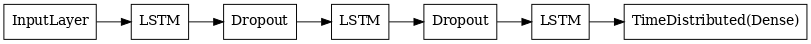

In [7]:
# keras.utils.plot_model(model, to_file='multilayer_perceptron_graph.png')
keras.utils.plot_model(model, to_file='model_3_256.png', show_shapes=False, show_dtype=False, 
                       show_layer_activations=False, rankdir='LR', dpi=70, show_layer_names=False)


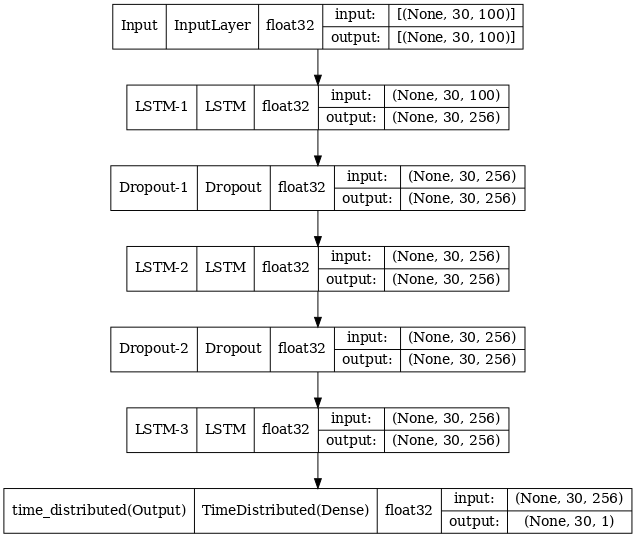

In [8]:
keras.utils.plot_model(model, to_file='model_3_256_detailed.png', show_shapes=True, show_dtype=True, 
                       show_layer_activations=False, rankdir='TB', dpi=70)

In [ ]:
NAME='selected_td'
model.compile(optimizer = 'adam',  loss='mae',  metrics=['mse', 'mae'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./data/model/covid_lstm_selected_td.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=50, restore_best_weights=True)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(NAME))
history = model.fit(train_ds, epochs=1024, 
                    validation_data=val_ds, 
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard]
                   )

### Selected model trained to convergence

In [9]:
# Selected model trained to convergence

train_ds, val_ds, test_ds = dsci.get_train_test_eval_ds()

input = keras.layers.Input(shape=(30,100), name='Input')
lstm1 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-1')(input)
dropout1 = keras.layers.Dropout(0.20, name='Dropout-1')(lstm1)
lstm2 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-2')(dropout1)
dropout2 = keras.layers.Dropout(0.20, name='Dropout-2')(lstm2)
lstm3 = keras.layers.LSTM(256, return_sequences=True,  name='LSTM-3')(dropout2)
output = keras.layers.Dense(1, name='Output')(lstm3)
model = keras.models.Model(inputs=input, outputs=output, name='Covid-Prediction-30-1-Densex2')
print(model.summary())

NAME='selected_model'
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01),  loss='mae',  metrics=['mse', 'mae'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./data/model/covid_lstm_selected.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=20, restore_best_weights=True)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(NAME))
history = model.fit(train_ds, epochs=1024, 
                    validation_data=val_ds, 
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard]
                   )

Model: "Covid-Prediction-30-1-Densex2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 30, 100)]         0         
                                                                 
 LSTM-1 (LSTM)               (None, 30, 256)           365568    
                                                                 
 Dropout-1 (Dropout)         (None, 30, 256)           0         
                                                                 
 LSTM-2 (LSTM)               (None, 30, 256)           525312    
                                                                 
 Dropout-2 (Dropout)         (None, 30, 256)           0         
                                                                 
 LSTM-3 (LSTM)               (None, 30, 256)           525312    
                                                                 
 Output (Dense)              (None, 3

2022-02-26 07:50:25.112717: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


1201/1201 [==============================] - 142s 115ms/step - loss: 6904.7598 - mse: 1051213120.0000 - mae: 6904.7852 - val_loss: 6453.9409 - val_mse: 1105392896.0000 - val_mae: 6453.9409
Epoch 2/1024
1201/1201 [==============================] - 142s 118ms/step - loss: 6179.2319 - mse: 1029391616.0000 - mae: 6179.2554 - val_loss: 5955.1670 - val_mse: 1085113216.0000 - val_mae: 5955.1665
Epoch 3/1024
1201/1201 [==============================] - 143s 119ms/step - loss: 5847.4043 - mse: 1011740480.0000 - mae: 5847.4312 - val_loss: 5748.2661 - val_mse: 1071805120.0000 - val_mae: 5748.2671
Epoch 4/1024
1201/1201 [==============================] - 143s 119ms/step - loss: 5646.3711 - mse: 1000044032.0000 - mae: 5646.3960 - val_loss: 5466.9531 - val_mse: 1061515072.0000 - val_mae: 5466.9492
Epoch 5/1024
1201/1201 [==============================] - 143s 118ms/step - loss: 5394.6538 - mse: 986333952.0000 - mae: 5394.6738 - val_loss: 5147.0137 - val_mse: 1044074432.0000 - val_mae: 5147.0142
Epoc

In [26]:
# Complex model multi dense

train_ds, val_ds, test_ds = dsci.get_train_test_eval_ds()

input = keras.layers.Input(shape=(30,101), name='Input')
lstm1 = keras.layers.LSTM(256, return_sequences=True, activity_regularizer=tf.keras.regularizers.L2(0.01), name='LSTM-1')(input)
dropout1 = keras.layers.Dropout(0.20, name='Dropout-1')(lstm1)
lstm2 = keras.layers.LSTM(256, return_sequences=True, activity_regularizer=tf.keras.regularizers.L2(0.01), name='LSTM-2')(dropout1)
dropout2 = keras.layers.Dropout(0.20, name='Dropout-2')(lstm2)
lstm3 = keras.layers.LSTM(256, return_sequences=True, activity_regularizer=tf.keras.regularizers.L2(0.01), name='LSTM-3')(dropout2)
dense = keras.layers.Dense(128, name='Dense', activation='relu')(lstm3)
output = keras.layers.Dense(1, name='Output')(dense)
model = keras.models.Model(inputs=input, outputs=output, name='Covid-Prediction-30-1-Densex2')


NAME='densex2c'
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),  loss='mse',  metrics=['mse', 'mae'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./data/model/covid_lstm_densex2c.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mse', patience=20, restore_best_weights=True)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(NAME))
history = model.fit(train_ds, epochs=1024, batch_size=128,
                    validation_data=val_ds, 
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard]
                   )

/home/noah/projects/drexel/dsci592/DS-capstone-pt1/env/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/1024
    973/Unknown - 113s 113ms/step - loss: nan - mse: nan - mae: nan

KeyboardInterrupt: 

In [ ]:
# Complex model one dense, batch normalization

train_ds, val_ds, test_ds = dsci.get_train_test_eval_ds()

input = keras.layers.Input(shape=(30,101), name='Input')
lstm1 = keras.layers.LSTM(256, return_sequences=True, name='LSTM-1')(input)
dropout1 = keras.layers.Dropout(0.20, name='Dropout-1')(lstm1)
batchnorm1 = keras.layers.BatchNormalization(name='Batch-Normalization-1')(dropout1)
lstm2 = keras.layers.LSTM(256, return_sequences=True,  name='LSTM-2')(batchnorm1)
dropout2 = keras.layers.Dropout(0.20, name='Dropout-2')(lstm2)
batchnorm2 = keras.layers.BatchNormalization(name='Batch-Normalization-2')(dropout2)
lstm3 = keras.layers.LSTM(256, return_sequences=True,  name='LSTM-3')(batchnorm2)
dropout3 = keras.layers.Dropout(0.20, name='Dropout-3')(lstm3)
batchnorm3 = keras.layers.BatchNormalization(name='Batch-Normalization-3')(dropout3)
output = keras.layers.Dense(1, name='Output')(batchnorm3)
model = keras.models.Model(inputs=input, outputs=output, name='Covid-Prediction-30-1-BatchNorm')

model.summary()

NAME='batchnorm'
model.compile(optimizer = 'adam',  loss='mae',  metrics=['mse', 'mae'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./data/model/covid_lstm_batchnorm.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=20, restore_best_weights=True)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(NAME))
history = model.fit(train_ds, epochs=1024, 
                    validation_data=val_ds, 
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard]
                   )


In [ ]:
# I added this to the data preprocessing, so not required

class TimeEncoding(keras.layers.Layer):
    """ Layer to encode cyclical and continuous time.  
    Input should an n x 1 array or vector of integers.  
    Integers represent number of time units (i.e., days) from the starting point"""

    def __init__(self, cyclical_interval=365, continuous_interval=3650 , **kwargs):
        self.cyclical_interval = cyclical_interval
        self.continuous_interval = continuous_interval
        super(TimeEncoding, self).__init__(**kwargs)

    def call(self, x):
        
        cyclical_sin = np.sin((x * 2 * np.pi)/self.cyclical_interval)
        cyclical_cos = np.cos((x * 2 * np.pi)/self.cyclical_interval)
        continuous_sin = np.sin((x * 2 * np.pi)/self.continuous_interval)
        continuous_cos = np.cos((x * 2 * np.pi)/self.continuous_interval)
        
        return keras.layers.concatenate([cyclical_sin, cyclical_cos, continuous_sin, continuous_cos], axis=1)
        

In [ ]:
time_encoding = TimeEncoding()
x = np.arange(30)/1.0
x = x[:, tf.newaxis]
time_encoding(x)

input = keras.layers.Input(shape=(30,92))
lstm1 = keras.layers.LSTM(512, return_sequences=True)(input)
dropout1 = keras.layers.Dropout(0.20)(lstm1)
lstm2 = keras.layers.LSTM(512, return_sequences=True)(dropout1)
dropout2 = keras.layers.Dropout(0.20)(lstm2)
lstm3 = keras.layers.LSTM(512, return_sequences=True)(dropout2)
dropout3 = keras.layers.Dropout(0.20)(lstm3)
lstm4 = keras.layers.LSTM(512, return_sequences=True)(dropout3)
dropout4 = keras.layers.Dropout(0.20)(lstm4)
lstm5 = keras.layers.LSTM(512)(dropout4)
output = keras.layers.Dense(1)(lstm5)
model = keras.models.Model(inputs=input, outputs=output)


Output with 5 LSTM @512, one dense layer

Epoch 1/32
1256/1256 [==============================] - 854s 677ms/step - loss: 1525.3854 - mse: 3823870.7500 - mae: 1525.3854 - val_loss: 1395.9611 - val_mse: 3222036.5000 - val_mae: 1395.9611
Epoch 2/32
1256/1256 [==============================] - 860s 685ms/step - loss: 1306.3831 - mse: 2720509.2500 - mae: 1306.3831 - val_loss: 1268.0597 - val_mse: 2458543.2500 - val_mae: 1268.0597
Epoch 3/32
1256/1256 [==============================] - 861s 686ms/step - loss: 1224.3491 - mse: 2193218.7500 - mae: 1224.3491 - val_loss: 1221.3195 - val_mse: 2095028.1250 - val_mae: 1221.3195
Epoch 4/32
1256/1256 [==============================] - 861s 685ms/step - loss: 1190.3538 - mse: 1940674.8750 - mae: 1190.3538 - val_loss: 1205.6909 - val_mse: 1935832.7500 - val_mae: 1205.6909
Epoch 5/32
1256/1256 [==============================] - 857s 682ms/step - loss: 1179.1588 - mse: 1829032.5000 - mae: 1179.1588 - val_loss: 1197.5588 - val_mse: 1859381.2500 - val_mae: 1197.5588
Epoch 6/32
1256/1256 [==============================] - 857s 682ms/step - loss: 1173.8285 - mse: 1778276.3750 - mae: 1173.8285 - val_loss: 1195.9708 - val_mse: 1827763.8750 - val_mae: 1195.9708
Epoch 7/32
1256/1256 [==============================] - 858s 683ms/step - loss: 1170.9568 - mse: 1751288.7500 - mae: 1170.9568 - val_loss: 1193.4899 - val_mse: 1804784.8750 - val_mae: 1193.4899
Epoch 8/32
1256/1256 [==============================] - 859s 684ms/step - loss: 1168.4807 - mse: 1736100.6250 - mae: 1168.4807 - val_loss: 1190.9672 - val_mse: 1791784.7500 - val_mae: 1190.9672
Epoch 9/32
1256/1256 [==============================] - 856s 682ms/step - loss: 1166.9685 - mse: 1730238.2500 - mae: 1166.9685 - val_loss: 1191.2921 - val_mse: 1792275.2500 - val_mae: 1191.2921
Epoch 10/32
1256/1256 [==============================] - 855s 681ms/step - loss: 1166.2148 - mse: 1729396.2500 - mae: 1166.2148 - val_loss: 1189.8693 - val_mse: 1789450.0000 - val_mae: 1189.8693
Epoch 11/32
1256/1256 [==============================] - 856s 681ms/step - loss: 1165.9210 - mse: 1729189.6250 - mae: 1165.9210 - val_loss: 1190.8143 - val_mse: 1792432.6250 - val_mae: 1190.8143
Epoch 12/32
1256/1256 [==============================] - 856s 682ms/step - loss: 1165.8933 - mse: 1730290.7500 - mae: 1165.8933 - val_loss: 1190.2284 - val_mse: 1791079.6250 - val_mae: 1190.2284
Epoch 13/32
1256/1256 [==============================] - 857s 682ms/step - loss: 1165.8029 - mse: 1731005.8750 - mae: 1165.8029 - val_loss: 1189.7284 - val_mse: 1790104.0000 - val_mae: 1189.7284
Epoch 14/32
1256/1256 [==============================] - 854s 680ms/step - loss: 1165.6666 - mse: 1729771.0000 - mae: 1165.6666 - val_loss: 1190.9232 - val_mse: 1793442.3750 - val_mae: 1190.9232
Epoch 15/32
1256/1256 [==============================] - 853s 680ms/step - loss: 1166.0372 - mse: 1731329.2500 - mae: 1166.0372 - val_loss: 1190.1742 - val_mse: 1791922.6250 - val_mae: 1190.1742
Epoch 16/32
 532/1256 [===========>..................] - ETA: 7:34 - loss: 1170.4701 - mse: 1743321.3750 - mae: 1170.4701

In [22]:
# train_ds, val_ds, test_ds = dsci.get_train_test_eval_ds()
train_ds, val_ds, test_ds = dsci.get_train_test_eval_ds(train='./data/train7/x_*.npy', test='./data/test7/x_*.npy', eval_='./data/eval7/x_*.npy', days_to_predict=7)
count = 0
for ds in [train_ds, val_ds, test_ds]:
    for x, _ in ds:
        count += x.shape[0]
count

1688712